### Demo of running the notebook with full code

**Import all modules and functions**

In [1]:
from IPython.core.display import display, HTML
toggle_code_str = '''
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Source Code"></form>
'''

toggle_code_prepare_str = '''
    <script>
    function code_toggle() {
        if ($('div.cell.code_cell.rendered.selected div.input').css('display')!='none'){
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
    }
    </script>

'''

display(HTML(toggle_code_prepare_str + toggle_code_str))

def toggle_code():
    display(HTML(toggle_code_str))

# import modules

import numpy as np
import seaborn as sns

import pandas as pd
from pandas import DataFrame
from pandas import concat

from sklearn import base
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.cbook import boxplot_stats

#%%
# model score function
def model_score_rmse(Y):
    '''
    Parameters
    ----------
    Y : dataframe
        with timestamp as index, column 0 as true values, and column 1 as 
        predicted values.

    Returns
    -------
    float value
        RMSE.
    '''
    
    metric_rmse = np.sqrt(mean_squared_error(Y[Y.columns[0]], Y[Y.columns[1]]))
    
    metric_cv_rmse = (metric_rmse / Y[Y.columns[0]].mean()) * 100
    
    return metric_rmse, metric_cv_rmse

# meter reading comparison plot
def plot_pred(Y):
    '''
    Parameters
    ----------
    Y : dataframe
        timestamp as index, first column of true y, 2nd column of predicted y.

    Returns
    -------
    A figure of time series plot

    '''
    
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d, %A'))
    ax.xaxis.set_major_locator(mdates.DayLocator(interval = 1))
    
    ax.plot(Y.index, Y[Y.columns[0]], label = 'true')
    ax.plot(Y.index, Y[Y.columns[1]], label = 'predicted')
    
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    
    plt.xlabel('month-date')
    plt.ylabel('hourly electricity load (kWh)')
    plt.legend(title='load profile type')

def create_time_steps(length):
    
    return list(range(-length, 0))

def multi_step_plot(hist, true_future, prediction, baseline):
  
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(hist))
    num_out = len(true_future)
    
    plt.plot(num_in, np.expm1(hist), label='History')
    plt.plot(np.arange(num_out), np.expm1(true_future), 'g-',
             label='True Future')
    
    if prediction.any():
      plt.plot(np.arange(num_out), np.expm1(prediction), 'ro',
               label='Predicted Future (Proposed)')
    
    if baseline.any():
      plt.plot(np.arange(num_out), np.expm1(baseline), 'bo',
               label='Predicted Future (Baseline)')
    
    plt.legend(loc='upper left', prop = {'size': 14})
    plt.xlabel('time (hour)')
    plt.ylabel('hourly electricity load (kWh)')
    plt.show()

# add time features
def time_feature(X):
        ''' add time features to X, with timestamps as index '''
        
        X['month'] = X.index.to_series().apply(lambda x: x.month)
        X['week'] = X.index.to_series().apply(lambda x: x.week)
        X['day'] = X.index.to_series().apply(lambda x: x.dayofweek)
        X['hour'] = X.index.to_series().apply(lambda x: x.hour)
        
        # Cyclic encoding of periodic features
        X['hour_x'] = np.cos(2*np.pi*X['hour']/24)
        X['hour_y'] = np.sin(2*np.pi*X['hour']/24)
        
        return X

class X_preprocessor(base.BaseEstimator, base.TransformerMixin):
    
    # count missing values
    def count_miss(self, X):
        ''' return a dataframe of missing counts and percentage
        for each feature'''
    
        total = X.isnull().sum().sort_values(ascending=False)
        ratio = (X.isnull().sum()/X.isnull().count()).sort_values(ascending=False)
        missing_data = pd.concat([total, ratio], axis=1, keys=['Total', 'Ratio'])
        
        return missing_data
    
    # linear interpolate of missing values
    def linear_interpolate_miss(self, X, lst):
        ''' linear interpolate missing features given in lst '''
        
        for ele in lst:
            X[ele] = X[ele].interpolate(method='linear', limit_direction='forward', axis=0)
        
        return X      
    
    # add time features
    def time_feature(self, X):
        ''' add time features to X, with timestamps as index '''
        
        X['month'] = X.index.to_series().apply(lambda x: x.month)
        X['week'] = X.index.to_series().apply(lambda x: x.week)
        X['day'] = X.index.to_series().apply(lambda x: x.dayofweek)
        X['hour'] = X.index.to_series().apply(lambda x: x.hour)
        
        # Cyclic encoding of periodic features
        X['hour_x'] = np.cos(2*np.pi*X['hour']/24)
        X['hour_y'] = np.sin(2*np.pi*X['hour']/24)
        
        return X
    
    def fit(self, X, y=None):
        # This transformer doesn't need to learn anything about the data,
        # so it can just return self without any further processing
        return self
    
    def transform(self, X):
        # Return an array with the same number of rows as X and transformed columns
        
        # drop not needed columns
        X = X.drop(['meter'], axis = 1)
        # sort by building id, then timestamp, ready for missing value handling
        X = X.sort_values(by = ['building_id', 'timestamp'])
        
        # check missing stats
        missing_data = self.count_miss(X)

        # remove high missing percentage features (precip_depth_1_hr)
        X = X.drop(['precip_depth_1_hr'], axis = 1)
        
        # remove high missing percentage features (cloud_coverage)
        X = X.drop(['cloud_coverage'], axis = 1)
        
        # replace with median (sea_level_pressure)
        X['sea_level_pressure'] = X['sea_level_pressure']. \
            apply(pd.to_numeric, errors='coerce').fillna(X['sea_level_pressure'].median())
        
        # linear interpolation of all missing features (< 1.7%)
        lst = list(missing_data.index.values[3:7])
        X = self.linear_interpolate_miss(X, lst)
        
        
        # add time features
        X = self.time_feature(X)
        
        # dummy values for categorical features
        cat_features = ['site_id', 'primary_use']
        X = pd.get_dummies(X, columns = cat_features)
        
        return X

class X_num_scaler(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, num_cols, scaler):
        self.num_cols = num_cols  # We will need these in transform()
        self.scaler = scaler
    
    def fit(self, X, y=None):
        # scaler fit to numerical columns
        
        # cat and num dataframe
        num = X[self.num_cols]
                
        return self.scaler.fit(num)
    
    def transform(self, X):
        # Return an array with the same number of rows as X and scaled
        # numerical columns, unchanged categorical columns
        
        # cat and num dataframe
        num = X[self.num_cols]
        cat = X.drop([self.num_cols[i] for i in range(len(self.num_cols))], axis = 1)
        
        # transform numerical features
        num_scaled = pd.DataFrame(self.scaler.transform(num)).set_index(num.index)
        num_scaled.columns = num.columns
        
        # concat back with cat features
        X_scaled = pd.concat([num_scaled, cat], axis=1)
        
        return X_scaled

# Series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
    
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	
    # put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	
    # drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
    
	return agg

# plot model convergence
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

def create_Y_triplets(df_test_reframed, y_test, y_test_hat, n_features, n_lag_hours, i):
    
    hist = test_reframed.values[i, [n_features * k for k in range(n_lag_hours)]]
    truth = np.concatenate( y_test, axis=0 )
    pred = np.concatenate( y_test_hat, axis=0 )
    
    return hist, truth, pred

def baseline_predict(df_train, df_test, n_lag_hours, d_pre_days, hist_reps):
    
    base = []
    
    t_pred = df_test.iloc[n_lag_hours : n_lag_hours + d_pre_days * 24, :].index
    
    for i in range(hist_reps):
        
        t_baseline_hist = t_pred - pd.to_timedelta( 7 * (i + 1), unit = 'days')
        
        base.append (df_train.loc[t_baseline_hist]['meter_reading'].values)

    return np.mean(np.array(base), axis = 0)

**Defind your inputs**
* 1. d_lag: past days used for prediction
* 2. d_pre: days (or hours, if it is less than 1) the model predicts. Suggested values are *1 hour or 3 hours*. Default is 3 hours.
* 3. d_pre_days: days you would like to predict. Suggested values are *1 day, 2 day or 3 days*. Default is 1 day.
* 4. raw_data: sample raw data (pickle file) --> 1 year electric load files of one building

In [2]:
#%%
# model settings (CHECK THESE EVERYTIME RUN THE PROGRAM)

d_lag = 5

d_pre = 3/24

d_pre_days = 1

df_bldg = pd.read_pickle("./raw_data.pkl")

**A peek into the raw data**

In [3]:
toggle_code()

df_bldg.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,,,,,,,,
2016-01-01 00:00:00,148,0,47.2,1,3,174601,1960.0,12.0,3.8,NaN,2.4,NaN,1020.9,240.0,3.1
2016-01-01 01:00:00,148,0,94.3,1,3,174601,1960.0,12.0,3.7,0.0,2.4,NaN,1021.6,230.0,2.6
2016-01-01 02:00:00,148,0,94.6,1,3,174601,1960.0,12.0,2.6,0.0,1.9,NaN,1021.9,0.0,0.0
2016-01-01 03:00:00,148,0,95.1,1,3,174601,1960.0,12.0,2.0,0.0,1.2,NaN,1022.3,170.0,1.5
2016-01-01 04:00:00,148,0,93.5,1,3,174601,1960.0,12.0,2.3,0.0,1.8,NaN,1022.7,110.0,1.5


**A further investigation of the load profiles:**

Lots of zeros while high meter readings, a natural way is log transformation

       meter_reading
count    8784.000000
mean      200.938410
std        90.185951
min         2.489800
25%       133.800000
50%       172.700000
75%       280.525000
max       497.700000


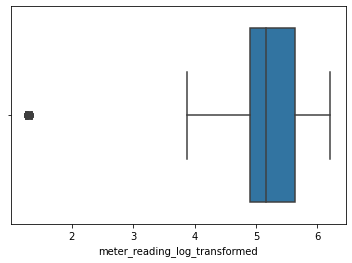

In [4]:
toggle_code()

#%%
# Y values investigation
X = df_bldg.drop(['meter_reading'], axis = 1)
Y = df_bldg.loc[:, ['meter_reading']]

# stats
print(Y.describe())

# target transformations
Y['meter_reading_log_transformed'] = np.log1p(Y['meter_reading'])

# distplot and boxplot for outlier detections
sns.boxplot(Y['meter_reading_log_transformed'], showfliers = True)    

# find outliers
outliers = [y for stat in boxplot_stats(Y['meter_reading_log_transformed']) for y in stat['fliers']]

**Split the data into train and test set**

In [5]:
toggle_code()

patience_turn = 60

# define days used for training
n_train_days = 280

# define historic hours used for predictions
n_lag_hours = int(24 * d_lag)

# define hours in the future for predictions
n_pre_hours = int(24 * d_pre)

# training hours based on days for training
n_train_hours = 24 * n_train_days

#%%
# train & test split

train = df_bldg.iloc[:n_train_hours, :]
test = df_bldg.iloc[n_train_hours-n_lag_hours:, :]

train_X = train.drop(['meter_reading'], axis = 1)
train_Y = train.loc[:, ['meter_reading']]

test_X = test.drop(['meter_reading'], axis = 1)
test_Y = test.loc[:, ['meter_reading']]

**Preprocess train and test set:**
* Handling missing values
* Dealing with outliers
* Feature engineering
* Normalizations

In [6]:
toggle_code()

#%%
# train set preparation

# initialize preprocessor
preprocessor = X_preprocessor()
# preprocess X_train
train_X_preprocessed = preprocessor.transform(train_X)

# initialize scaler
num_cols = list(train_X_preprocessed.columns[:15])
scaler = X_num_scaler(num_cols, StandardScaler())

# fit and transform X_train
scaler.fit(train_X_preprocessed)
train_X_scaled = scaler.transform(train_X_preprocessed)

# log transform of Y_train
train_Y_scaled = np.log1p(train_Y)

# concat for transformed and scaled train set
train_scaled = pd.concat([train_Y_scaled, train_X_scaled], axis = 1)


#%%
# test set preparation

# initialize preprocessor
preprocessor = X_preprocessor()
# preprocess X_test
test_X_preprocessed = preprocessor.transform(test_X)

# initialize scaler
num_cols = list(test_X_preprocessed.columns[:15])
# transform X_test
test_X_scaled = scaler.transform(test_X_preprocessed)

# log transform of Y_test
test_Y_scaled = np.log1p(test_Y)

# concat for transformed and scaled train set
test_scaled = pd.concat([test_Y_scaled, test_X_scaled], axis = 1)

**Time to feed the data into the pipeline**

* First, set up the hyperparameter search with Keras-tuner.

In [7]:
toggle_code()

#%%
# reframe train set

n_features = train_scaled.shape[1]

train_reframed = series_to_supervised(train_scaled, 
                                      n_lag_hours, n_pre_hours)

n_obs = n_lag_hours * n_features

# split into input and outputs

x_train, y_train = train_reframed.values[:, :n_obs], \
    train_reframed.values[:, [-n_features * (n_pre_hours - i) for i in range(n_pre_hours)]]

# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], n_lag_hours, n_features))

# print(x_train.shape, y_train.shape)

import tensorflow as tf

def build_model(hp):
     
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units=hp.Int('units', min_value=32, max_value=128, step=16), 
                                   return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.LSTM(units=hp.Int('units', min_value=16, max_value=96, step=16)))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Dense(n_pre_hours))

    model.summary()

    model.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])))
    
    return model

import kerastuner

project_path = '{}d_{}d'.format(d_lag, d_pre)

tuner = kerastuner.tuners.Hyperband(build_model, objective='val_loss', max_epochs = 1000, 
                                    directory='hypertuned', project_name = project_path)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 32)           6528      
_________________________________________________________________
dropout (Dropout)            (None, 120, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 14,947
Trainable params: 14,947
Non-trainable params: 0
_________________________________________________________________


* A summary of hyperparameter search (based on which we will finalize our LSTM model structure)

In [8]:
toggle_code()

tuner.search(x_train, y_train, epochs=1000, batch_size=32, validation_split=0.2, shuffle=False, verbose=0)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 80)           31680     
_________________________________________________________________
dropout (Dropout)            (None, 120, 80)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 243       
Total params: 83,443
Trainable params: 83,443
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 112)          58688     
_________________________________________________________________
dropout (Dropout)            (None, 120, 112)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 112)               100800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 112)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 339       
Total params: 159,827
Trainable params: 159,827
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 64)           21248     
_________________________________________________________________
dropout (Dropout)            (None, 120, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 54,467
Trainable params: 54,467
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 32)           6528      
_________________________________________________________________
dropout (Dropout)            (None, 120, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 14,947
Trainable params: 14,947
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 32)           6528      
_________________________________________________________________
dropout (Dropout)            (None, 120, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 14,947
Trainable params: 14,947
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 80)           31680     
_________________________________________________________________
dropout (Dropout)            (None, 120, 80)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 243       
Total params: 83,443
Trainable params: 83,443
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 96)           44160     
_________________________________________________________________
dropout (Dropout)            (None, 120, 96)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 291       
Total params: 118,563
Trainable params: 118,563
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 112)          58688     
_________________________________________________________________
dropout (Dropout)            (None, 120, 112)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 112)               100800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 112)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 339       
Total params: 159,827
Trainable params: 159,827
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 112)          58688     
_________________________________________________________________
dropout (Dropout)            (None, 120, 112)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 112)               100800    
_________________________________________________________________
dropout_1 (Dropout)          (None, 112)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 339       
Total params: 159,827
Trainable params: 159,827
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 80)           31680     
_________________________________________________________________
dropout (Dropout)            (None, 120, 80)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 243       
Total params: 83,443
Trainable params: 83,443
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 48)           12864     
_________________________________________________________________
dropout (Dropout)            (None, 120, 48)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 48)                18624     
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 147       
Total params: 31,635
Trainable params: 31,635
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 128)          75264     
_________________________________________________________________
dropout (Dropout)            (None, 120, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 207,235
Trainable params: 207,235
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 96)           44160     
_________________________________________________________________
dropout (Dropout)            (None, 120, 96)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 291       
Total params: 118,563
Trainable params: 118,563
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 64)           21248     
_________________________________________________________________
dropout (Dropout)            (None, 120, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 54,467
Trainable params: 54,467
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 48)           12864     
_________________________________________________________________
dropout (Dropout)            (None, 120, 48)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 48)                18624     
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 147       
Total params: 31,635
Trainable params: 31,635
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 64)           21248     
_________________________________________________________________
dropout (Dropout)            (None, 120, 64)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 54,467
Trainable params: 54,467
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 32)           6528      
_________________________________________________________________
dropout (Dropout)            (None, 120, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 99        
Total params: 14,947
Trainable params: 14,947
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 96)           44160     
_________________________________________________________________
dropout (Dropout)            (None, 120, 96)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 96)                74112     
_________________________________________________________________
dropout_1 (Dropout)          (None, 96)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 291       
Total params: 118,563
Trainable params: 118,563
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 128)          75264     
_________________________________________________________________
dropout (Dropout)            (None, 120, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 207,235
Trainable params: 207,235
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 128)          75264     
_________________________________________________________________
dropout (Dropout)            (None, 120, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 207,235
Trainable params: 207,235
Non-trainable params: 0
_________________________________________________________________


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 48)           12864     
_________________________________________________________________
dropout (Dropout)            (None, 120, 48)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 48)                18624     
_________________________________________________________________
dropout_1 (Dropout)          (None, 48)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 147       
Total params: 31,635
Trainable params: 31,635
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Oracle triggered exit


* What's the best model looking like?

In [9]:
toggle_code()

models = tuner.get_best_models(num_models=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 120, 128)          75264     
_________________________________________________________________
dropout (Dropout)            (None, 120, 128)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 207,235
Trainable params: 207,235
Non-trainable params: 0
_________________________________________________________________


* Since Keras tuner only did a preliminary parameter search, we will continue fit the best model with train dataset.

    The train and validation loss plot shows the model learing progress. It also helps to indicate when to stop to avoid overfitting.

Epoch 1/400

Epoch 00001: val_loss improved from inf to 0.02660, saving model to best_model_5d_to_0.125d
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: best_model_5d_to_0.125d\assets
165/165 - 23s - loss: 0.1645 - val_loss: 0.0266
Epoch 2/400

Epoch 00002: val_loss improved from 0.02660 to 0.02417, saving model to best_model_5d_to_0.125d
INFO:tensorflow:Assets written to: best_model_5d_to_0.125d\assets
165/165 - 23s - loss: 0.1438 - val_loss: 0.0242
Epoch 3/400

Epoch 00003: val_loss did not improve from 0.02417
165/165 - 19s - loss: 0.1283 - val_loss: 0.0262
Epoch 4/400

Epoch 00004: val_loss improved from 0.02417 to 0.01787, saving model to best_model_5d_to_0.125d
INFO:tensorflow:Assets written to: best_model_5d_to_0.125d\assets
165/165 - 24s - loss: 0.1156 - val_lo

Epoch 60/400

Epoch 00060: val_loss did not improve from 0.01402
165/165 - 26s - loss: 0.0509 - val_loss: 0.0170
Epoch 61/400

Epoch 00061: val_loss did not improve from 0.01402
165/165 - 25s - loss: 0.0516 - val_loss: 0.0366
Epoch 62/400

Epoch 00062: val_loss did not improve from 0.01402
165/165 - 25s - loss: 0.0491 - val_loss: 0.0254
Epoch 63/400

Epoch 00063: val_loss did not improve from 0.01402
165/165 - 26s - loss: 0.0491 - val_loss: 0.0484
Epoch 64/400

Epoch 00064: val_loss did not improve from 0.01402
165/165 - 25s - loss: 0.0484 - val_loss: 0.0309
Epoch 65/400

Epoch 00065: val_loss did not improve from 0.01402
165/165 - 26s - loss: 0.0495 - val_loss: 0.0426
Epoch 66/400

Epoch 00066: val_loss did not improve from 0.01402
165/165 - 26s - loss: 0.0480 - val_loss: 0.0349
Epoch 67/400

Epoch 00067: val_loss did not improve from 0.01402
165/165 - 26s - loss: 0.0487 - val_loss: 0.0350
Epoch 68/400

Epoch 00068: val_loss did not improve from 0.01402
165/165 - 26s - loss: 0.0496 - 

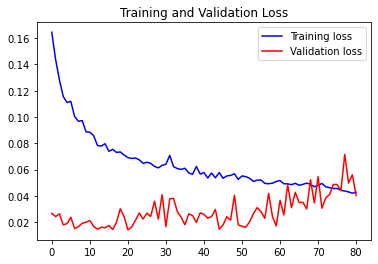

In [10]:
toggle_code()

model = models[0]

best_model_filepath = 'best_model_{}d_to_{}d'.format(d_lag, d_pre)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = patience_turn)

mc = tf.keras.callbacks.ModelCheckpoint(filepath = best_model_filepath, monitor='val_loss', 
                             mode='min', verbose=1, save_best_only=True)

history = model.fit(x_train, y_train, epochs=400, batch_size=32, validation_split=0.2, shuffle=False, 
                    verbose = 2, callbacks = [es, mc])

plot_train_history(history, 'Training and Validation Loss')

**Load the best model we have trained and use it to predict the future electricity loads (within your selected time frame).**

Default is 1 days (see d_pre_days)

A peek into the load predcition results (first several hours):

In [14]:
toggle_code()

#%%
# reframe test set
test_reframed = series_to_supervised(test_scaled, 
                                     n_lag_hours, n_pre_hours)

# split into input and outputs
x_test, y_test = test_reframed.values[:, :n_obs], \
    test_reframed.values[:, [-n_features * (n_pre_hours - i) for i in range(n_pre_hours)]]

# reshape input to be 3D [samples, timesteps, features]
x_test = x_test.reshape((x_test.shape[0], n_lag_hours, n_features))

best_model_filepath_2 = 'best_model_{}d_to_{}h'.format(d_lag, n_pre_hours)

model.save(best_model_filepath_2)

saved_best_model = tf.keras.models.load_model(best_model_filepath_2)

y_test_truth = []
y_test_hat = []
y_each_turn = {}

for i in range(0, d_pre_days * 24, n_pre_hours):
    
    if i == 0:
        
        # reframe test inputs from each row
        test_reframed_single_sample = test_reframed.iloc[i, :].values.reshape(1, -1)
        x_test_single_sample = test_reframed_single_sample[:, :n_obs]
        y_test_single_sample = test_reframed_single_sample[:, [-n_features * (n_pre_hours - i) for i in range(n_pre_hours)]]
        
        # reshape input to be 3D [samples, timesteps, features]
        x_test_single_sample = x_test_single_sample.reshape((x_test_single_sample.shape[0], n_lag_hours, n_features))
        
        # predict
        y_test_hat_single_sample = saved_best_model.predict(x_test_single_sample)
        
        # append to the list
        y_test_truth.extend(y_test_single_sample)
        y_test_hat.extend(y_test_hat_single_sample)
        
        # store prediction results in a dictionary
        y_each_turn[i] = y_test_hat_single_sample
        
    else:
        
        # reframe test inputs from each row
        test_reframed_single_sample = test_reframed.iloc[i, :].values.reshape(1, -1)
        x_test_single_sample = test_reframed_single_sample[:, :n_obs]
        y_test_single_sample = test_reframed_single_sample[:, [-n_features * (n_pre_hours - i) for i in range(n_pre_hours)]]
        
        # update test inputs with last turn's prediction results
        x_test_single_sample[:, [-(n_features * (n_pre_hours - i + n_pre_hours)) 
                                 for i in range(n_pre_hours)]] = y_each_turn[i-n_pre_hours]
        
        # reshape input to be 3D [samples, timesteps, features]
        x_test_single_sample = x_test_single_sample.reshape((x_test_single_sample.shape[0], n_lag_hours, n_features))
        
        # predict
        y_test_hat_single_sample = saved_best_model.predict(x_test_single_sample)
        
        # append to the list
        y_test_truth.extend(y_test_single_sample)
        y_test_hat.extend(y_test_hat_single_sample)
        
        # store prediction results in a dictionary
        y_each_turn[i] = y_test_hat_single_sample

#%%
# model prediction and invert back for comparison

hist, truth, pred = create_Y_triplets(test_reframed, y_test_truth, y_test_hat, n_features, n_lag_hours, 0)

y_test_compare = pd.concat([pd.DataFrame(np.expm1(truth)), 
                            pd.DataFrame(np.expm1(pred))], axis=1)

y_test_compare.columns = ['truth', 'predicted']

y_test_compare.head()

INFO:tensorflow:Assets written to: best_model_5d_to_3h\assets


,truth,predicted
0,140.8,161.187363
1,139.4,160.323120
2,138.9,162.198593
3,139.8,163.879059
4,143.6,169.739105


**How does the model perform?**

In [15]:
toggle_code()

#%%
# model evaluation
rmse, cv_rmse = model_score_rmse(y_test_compare.iloc[:, :])

print('model score (RMSE) is: \n', "{:.2f}".format(rmse))

print('model score (CV_RMSE %) is: \n', "{:.2f}".format(cv_rmse))

model score (RMSE) is: 
 29.11
model score (CV_RMSE %) is: 
 13.11


**How does the baseline model perform?**

The baseline model is the simple average of similar days in the past 3 weeks. You can modify parameters to tune your own baseline models.

In [16]:
toggle_code()

hist_reps = 3

baseline = baseline_predict(train_scaled, test_scaled, n_lag_hours, d_pre_days, hist_reps)

y_baseline_compare = pd.concat([pd.DataFrame(np.expm1(truth)), 
                            pd.DataFrame(np.expm1(baseline))], axis=1)

y_baseline_compare.columns = ['truth', 'baseline']

#%%
# baseline evaluation
baseline_rmse, baseline_cv_rmse = model_score_rmse(y_baseline_compare.iloc[:, :])

print('baseline model score (RMSE) is: \n', "{:.2f}".format(baseline_rmse))

print('baseline model score (CV_RMSE %) is: \n', "{:.2f}".format(baseline_cv_rmse))

baseline model score (RMSE) is: 
 48.55
baseline model score (CV_RMSE %) is: 
 21.86


**Finally, we plot all results together.**

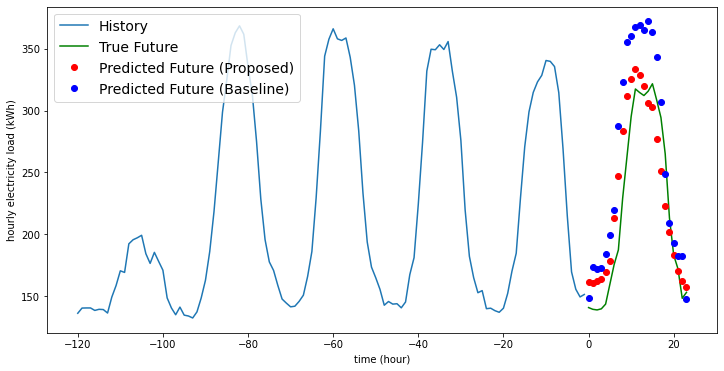

In [17]:
toggle_code()

# reg vs true profile comparison

multi_step_plot(hist, truth, pred, baseline)